# Answering Business Questions using SQL

In this project, we're going to answer business questions with SQL. More specifically, we will:

* Write a SQL query to extract the relevant data
* Create plots where necessary to visualize the data
* Write a short paragraph, drawing conclusions and explaining the data and/or visualizations.

We'll use the Chinook database, which is provided as a SQLite database file called `chinook.db`. A copy of the database schema is below.
![](https://www.basedonstatistics.com/wp-content/uploads/2018/06/chnk.png)

## Creating Helper Functions

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
%matplotlib inline

db = 'chinook.db'

def run_query(q: str)-> pd.DataFrame:
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c: str)-> None:
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables()-> None:
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(q)
    
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

We'll need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

## Selecting New Albums to Purchase

In [2]:
q_albums_to_purchase = '''
WITH

usa_tracks_sold AS
    (
     SELECT il.* FROM invoice_line il
     INNER JOIN invoice i ON il.invoice_id = i.invoice_id
     INNER JOIN customer c ON i.customer_id = c.customer_id
     WHERE c.country = "USA"
    )

SELECT
    g.name genre,
    COUNT(uts.invoice_line_id) tracks_sold,
    COUNT (uts.invoice_line_id) * 1.0 /  (
     SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(q_albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Before we go any further, let's define a helper function to make our plot more interesting for storytelling and visualization. Simple is the key here.

In [3]:
def get_color_list(
    n: int,
    hl_pos: [int],
    hl_c: str = 'slategrey',
    sd_c: str = 'lightgrey'
    )-> [str]:
    highlight_color = hl_c
    subdued_color   = sd_c
    cl = []
    for i in range(0,n):
        if i in hl_pos:
            cl.append(highlight_color)
        else:
            cl.append(subdued_color)
    return cl

print(get_color_list(5,[0,2,3],hl_c='red'))

['red', 'lightgrey', 'red', 'red', 'lightgrey']


In [4]:
# Set color palette
# http://tools.medialab.sciences-po.fr/iwanthue/

def hex_to_rgb(hex):
    hex = hex.lstrip('#')
    hlen = len(hex)
    return [int(hex[i:i+hlen//3], 16) for i in range(0, hlen, hlen//3)]

def normalize_primary(hex: str)-> tuple:
    return tuple(map(lambda x: x/255, hex_to_rgb(hex)))
    
def normalize_subdued(hex: str,a: float)-> tuple:
    c = hex_to_rgb(hex)
    return (c[0]/255,c[1]/255,c[2]/255,a)
                 
def gen_primary(colors: dict)-> dict:
    return {name+'_p':normalize_primary(rgb) for name, rgb in colors.items()}

def gen_subdued(colors: dict, alpha: float = 0.25)-> dict:
    return {name+'_s':normalize_subdued(rgb, alpha) for name, rgb in colors.items()}

scheme_A = { 
    'red': "#ca0e69",
    'green': "#009a6b",
    'purple': "#8960b3",
    'orange': "#ff8c53",
    'lime': "#909e3f"
}
                 
def normalize_colors(colors: dict, alpha: float = 0.25)-> dict:
    np = gen_primary(colors)
    ns = gen_subdued(colors, alpha)
    np.update(ns)
    return np

cpA = normalize_colors(scheme_A)
# print(cpA)

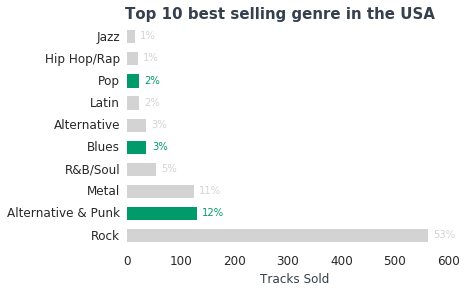

In [5]:
genre_sales_usa = run_query(q_albums_to_purchase)
genre_sales_usa.set_index('genre',inplace=True)

genre_sales_color = get_color_list(
                        len(list(genre_sales_usa.index)),
                        [1,4,7],
                        cpA['green_p'])

fig, ax = plt.subplots(figsize=(6,4))

genre_sales_usa.tracks_sold.plot.barh(
    ax=ax,
    xlim=(0,625),
    width=0.6,
    linewidth=0,
    fontsize=12,
    color = genre_sales_color)

plt.ylabel('')

label_horspace = 10
label_vertspace = 0.1

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, 'tracks_sold']
    label = (genre_sales_usa.loc[label, 'percentage_sold'] * 100
            ).astype(int).astype(str) + '%'
    plt.text(score + label_horspace,
             i - label_vertspace,
             str(label),
             color=genre_sales_color[i])

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,         # ticks along the top edge are off
    top=False,         # ticks along the top edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

fig.text(0.12, 0.92, 'Top 10 best selling genre in the USA', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_xlabel('Tracks Sold', fontsize=12, color = '#333F4B')
sns.despine(ax=ax,left=True, bottom=True, top=True, right=True)

plt.show()

We have now shown the horizontal bar plot, based on the sales data in the USA, we should purchase the album of:

* Red Tone (Punk, 12%)
* Slim Jim Bites (Blues, 3%)
* Meteor and the Girls (Pop, 2%)

In total, they represent only 17% of total sales, which is not so much compared to Rock genre, which covers for 53% of sales.

## Evaluating Sales Employee Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.

In [6]:
q_sales_perf = '''
WITH

sales_rep AS (
    SELECT
        i.customer_id,
        c.support_rep_id,
        SUM(i.total) total
    FROM invoice i
    INNER JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY 1, 2
)


SELECT
    e.first_name || ' ' || e.last_name employee,
    e.hire_date,
    SUM(total) total_sales
FROM sales_rep sr
INNER JOIN employee e ON e.employee_id = sr.support_rep_id
GROUP BY 1
LIMIT 10;
'''

run_query(q_sales_perf)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


We have included the hire date to see the total sales relative to the employment period. 
Let's try to plot it with horizontal bar plot!

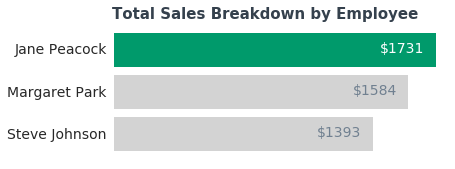

In [7]:
sales_perf = run_query(q_sales_perf)
sales_perf.set_index('employee',inplace=True)
sales_perf.sort_values('total_sales', inplace=True)

fig, ax = plt.subplots(figsize=(6,2.5))

sales_perf.total_sales.plot.barh(
    ax=ax,
    width=0.8,
    linewidth=0,fontsize=14,
    color=get_color_list(
                    len(list(sales_perf.index)),
                    [2],
                    cpA['green_p']))

plt.ylabel('')

label_horspace = 300
label_vertspace = 0.06

annotation_color = get_color_list(
                        len(list(sales_perf.index)),
                        [2],
                        hl_c='white',
                        sd_c='slategrey')

for i, label in enumerate(list(sales_perf.index)):
    score = sales_perf.loc[label, 'total_sales']
    label = '$' + (sales_perf.loc[label, 'total_sales']
            ).astype(int).astype(str)
    plt.text(score - label_horspace,
             i - label_vertspace,
             str(label),
             color=annotation_color[i],
             fontsize=14)

fig.text(0.12, 0.92, 'Total Sales Breakdown by Employee', fontsize=15, fontweight='black', color = '#333F4B')
sns.despine(ax=ax,left=True, bottom=True, top=True, right=True)
ax.tick_params(top="off", right="off", left="off", bottom="off", labelbottom=False)

plt.show()

On the one hand, Steve Johnson has the lowest total sales, but considering he was the newest sales rep hired out of the three, we can consider this normal. On the other hand, Jane Peacock has the highest total sales as she was hired the earliest out of the three. Meanwhile, Margaret Park placed in the middle.

## Analyzing Sales by Country

Our next task is to analyze the sales data for customers from each different country. We have been given guidance to use the country value from the `customers` table, and ignore the country from the billing address in the `invoice` table.

For each country, we need to calculate the following data:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Because there are a number of countries with only one customer, we should group these customers as "Other" in our analysis. We can use the following 'trick' to force the ordering of "Other" to last in our analysis.

In [8]:
q_sales_by_country = '''
WITH

sort_country AS (
    SELECT
        CASE
            WHEN ( 
                SELECT count(*)
                FROM customer
                WHERE country = c.country
                ) = 1 THEN 'Other'
            ELSE c.country
        END AS country,
        c.customer_id,
        il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
)

SELECT
    country,
    customers,
    total_sales,
    avg_sales_per_customer,
    avg_order
FROM (
    SELECT
        country,
        count(distinct sc.customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct sc.invoice_id) avg_order,
        SUM(unit_price) / count(distinct sc.customer_id) avg_sales_per_customer,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM sort_country sc
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
)
'''

run_query(q_sales_by_country)

,country,customers,total_sales,avg_sales_per_customer,avg_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


We will now create a visualization which demonstrates the data we collated in the previous step.

In [9]:
# This helper function will annotate directly 
# near the end of the bar,
# which will make our graphs way sleeker and cleaner
def direct_annotate(ax: plt.axes,
                    df: pd.DataFrame,
                    col: str,
                    color: [str],
                    prefix: str = '',
                    suffix: str = '',
                    hspace: float = 0.0,
                    vspace: float = 0.0,
                    fontsize: int = 14
                   ) -> None:
    for i, label in enumerate(list(df.index)):
        score = df.loc[label, col]
        label = prefix + (df.loc[label, col]).astype(int).astype(str) + suffix
        ax.text(score + hspace, # plus because x axis is extending right
                 i - vspace, # minus because y axis is extending down
                 str(label),
                 color=color[i],
                 fontsize=fontsize)

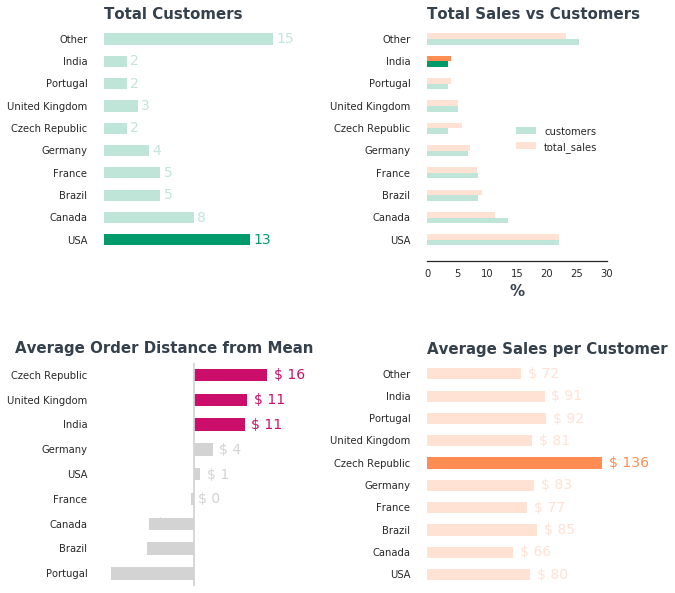

In [10]:
sales_by_country = run_query(q_sales_by_country)

sales_by_country.set_index("country", drop=True, inplace=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.8)
idx = len(list(sales_by_country.index))

########################################################################
# TOP LEFT - total customers per country 
cpc_cols = ["customers"]
custs_per_country = sales_by_country[cpc_cols].copy()
custs_per_country.index.name = ''

color_1a = get_color_list(idx,[0],cpA['green_p'],cpA['green_s'])

custs_per_country.plot.barh(
    ax=ax1,
    linewidth=0,
    color=[color_1a]
)
sns.despine(ax=ax1,left=True, bottom=True, top=True, right=True)
ax1.tick_params(top="off", right="off", left="off", bottom="off", labelbottom=False)
ax1.text(0, 9.92, 'Total Customers', fontsize=15, fontweight='black', color = '#333F4B')
ax1.set_ylabel('')
ax1.get_legend().remove()

direct_annotate(ax1,
                custs_per_country,
                'customers',
                color_1a,
                hspace=0.3, 
                vspace=0.15)

ax1.spines['left'].set_position(('outward', 10))

########################################################################
# TOP RIGHT - percentage of sales per country 
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = sales_by_country[cvd_cols].copy()
custs_vs_dollars.index.name = ''
color_2a = get_color_list(idx,[8],cpA['green_p'],cpA['green_s'])
color_2b = get_color_list(idx,[8],cpA['orange_p'],cpA['orange_s'])

# Convert the value to percentage
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
    
custs_vs_dollars.plot.barh(
    ax=ax2,
    linewidth=0,
    color=[color_2a,color_2b]
)
sns.despine(ax=ax2,left=True, bottom=False, top=True, right=True)
ax2.tick_params(top="off", right="off", left="off", bottom="on")
ax2.text(0, 9.92, 'Total Sales vs Customers', fontsize=15, fontweight='black', color = '#333F4B')
ax2.set_xlabel('%', fontsize=15, fontweight='black', color = '#333F4B')
ax2.set_ylabel('')

ax2.spines['left'].set_position(('outward', 10))
ax2.spines['bottom'].set_position(('outward', 10))

########################################################################
# BOTTOM LEFT - average order % difference from mean
avo_cols = ["avg_order"]
avg_order = sales_by_country[avo_cols].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.sort_values('avg_order',ascending=True, inplace=True)
# print(difference_from_avg)
# print(difference_from_avg.loc['Portugal'])

color_3a_bar = get_color_list(idx-1,
                          [6,7,8],
                          cpA['red_p']
                         )
color_3b_label = get_color_list(idx-1,
                          [0,1,2,3,4,5],
                          'lightgrey',
                          cpA['red_p'])
difference_from_avg.plot.barh(
    ax=ax3,
    linewidth=0,
    color=[color_3a_bar]
)

sns.despine(ax=ax3,left=True, bottom=True, top=True, right=True)
ax3.tick_params(top="off", right="off", left="off", bottom="off", labelbottom=False)
ax3.axvline(0, color='lightgrey')
ax3.text(-40, 8.92, 'Average Order Distance from Mean', fontsize=15, fontweight='black', color = '#333F4B')
# ax3.set_xlabel('USD', fontsize=15, fontweight='black', color = '#333F4B')
ax3.set_ylabel('')
ax3.get_legend().remove()

direct_annotate(ax3,
                difference_from_avg,
                'avg_order',
                color_3b_label,
                prefix='$ ',
                hspace=1.5, 
                vspace=0.15)

ax3.spines['left'].set_position(('outward', 10))
ax3.spines['bottom'].set_position(('outward', 10))

########################################################################
# BOTTOM RIGHT - average sales per customers in each countries
aspc_cols = ["avg_sales_per_customer"]
avg_sales_per_country = sales_by_country[aspc_cols].copy()
avg_sales_per_country.index.name = ''

color_4a = get_color_list(idx,[5],cpA['orange_p'],cpA['orange_s'])

avg_sales_per_country.plot.barh(
    ax=ax4,
    linewidth=0,
    color=[color_4a]
)
sns.despine(ax=ax4,left=True, bottom=True, top=True, right=True)
ax4.tick_params(top="off", right="off", left="off", bottom="off", labelbottom=False)
ax4.text(0, 9.92, 'Average Sales per Customer', fontsize=15, fontweight='black', color = '#333F4B')
ax4.set_ylabel('')
ax4.get_legend().remove()

direct_annotate(ax4,
                avg_sales_per_country,
                'avg_sales_per_customer',
                color_4a,
                prefix='$ ',
                hspace=5.3, 
                vspace=0.15)

ax4.spines['left'].set_position(('outward', 10))
ax4.spines['bottom'].set_position(('outward', 10))

########################################################################
plt.show()

Based on the above visualization, although USA has the most total customers, Czech Republic, UK, and India has more opportinity to increase the sales.

Since the sample size is not large enough to give us high confidence, we should proceed carefully to spend money on marketing campaign.

## Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In this instance, we have two edge cases to consider:

* Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
* Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

We're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

The query we will write categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
* Number of invoices
* Percentage of invoices

In [11]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    count(invoice_id)*100.0 / (
        SELECT COUNT(*) FROM invoice
        ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,81.433225
1,yes,114,18.566775


Album purchases covers 18.6% of purchases.
Based on this data, it would be wise to purchase only single tracks from albums.

# Conclusion

In this project, we have explored chinook database with deep emphasis on SQL workflow and storytelling by data visualization.

More specifically, we have analyzed and visualized the following tasks:

* Recommended new albums to purchase based on popular genres
* Evaluated sales employee performance
* Analyzed sales and total customers by country
* Recommended to buy only selected tracks instead of album